### Метрики классификации.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    OrdinalEncoder,
    TargetEncoder,
    FunctionTransformer,
)

sklearn.set_config(transform_output="pandas")

# models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    BaggingClassifier,
)
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

# for model learning
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score,
)


# tunning hyperparamters model
import optuna

from catboost import CatBoostClassifier

import lightgbm as lgb

import xgboost as xgb

In [2]:
data = pd.read_csv("./../data/microsoft_malware_detection.csv")

In [3]:
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Перед вами пердобработанный датасет от Microsoft. столбец  `HasDetections` - ваш таргет. Который отражает по имеющимся данным, данная программа является вирусом или нет. Датасет имеет дисбаланс классов. Хороша ли метрика `accuracy`?

1. Проверьте пропорцию классов

In [4]:
print("Всего:", data.shape)
print(
    "Класс 0: ",
    data[data["HasDetections"] == 0].shape,
    "Класс 1:",
    data[data["HasDetections"] == 1].shape,
)

Всего: (119952, 79)
Класс 0:  (99940, 79) Класс 1: (20012, 79)


In [5]:
types = pd.DataFrame(data.dtypes).reset_index()
types.groupby(0).count()

,index
0,
int64,27
float64,52


In [6]:
X = data.drop("HasDetections", axis=1).copy()
y = data["HasDetections"].copy()

num_of_unique = {}
for c in X.columns:
    num_of_unique[c] = data[c].nunique()
num_of_unique

{'EngineVersion': 38,
 'AppVersion': 67,
 'AvSigVersion': 841,
 'RtpStateBitfield': 6,
 'IsSxsPassiveMode': 2,
 'AVProductStatesIdentifier': 2638,
 'AVProductsInstalled': 5,
 'AVProductsEnabled': 5,
 'HasTpm': 2,
 'CountryIdentifier': 222,
 'CityIdentifier': 17765,
 'OrganizationIdentifier': 37,
 'GeoNameIdentifier': 245,
 'LocaleEnglishNameIdentifier': 196,
 'OsVer': 8,
 'OsBuild': 45,
 'OsSuite': 7,
 'OsPlatformSubRelease': 9,
 'OsBuildLab': 180,
 'SkuEdition': 8,
 'IsProtected': 2,
 'AutoSampleOptIn': 2,
 'SMode': 2,
 'IeVerIdentifier': 153,
 'SmartScreen': 12,
 'Firewall': 2,
 'UacLuaenable': 4,
 'Census_MDC2FormFactor': 12,
 'Census_OEMNameIdentifier': 1013,
 'Census_OEMModelIdentifier': 18520,
 'Census_ProcessorCoreCount': 17,
 'Census_ProcessorManufacturerIdentifier': 4,
 'Census_ProcessorModelIdentifier': 1814,
 'Census_PrimaryDiskTotalCapacity': 577,
 'Census_PrimaryDiskTypeName': 5,
 'Census_SystemVolumeTotalCapacity': 52088,
 'Census_HasOpticalDiskDrive': 2,
 'Census_TotalPh

In [7]:
nan_columns = X.isna().sum()
nan_columns = nan_columns[nan_columns > 0]
nan_columns

Series([], dtype: int64)

In [8]:
n_unique_cutoff = 30
numeric_columns = [b for b in num_of_unique.keys() if num_of_unique[b] > 2]
cat_columns = [c for c in num_of_unique.keys() if c not in numeric_columns]
# len(numeric_columns) + len(cat_columns) == len(list(X.columns))
numeric_columns

['EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'RtpStateBitfield',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IeVerIdentifier',
 'SmartScreen',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_ChassisTypeName',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_PowerPlatformRoleName',
 'Census_InternalBatteryNumberOfCharges',
 

2. Сделайте scaling данных

In [9]:
scaler = ColumnTransformer(
    [
        ("scaling_num_columns", StandardScaler(), numeric_columns),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

In [10]:
X_scaled = scaler.fit_transform(X)
X_scaled.head(10)

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Platform_windows7,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN
0,0.845336,0.590806,0.894582,0.164226,0.439021,-0.683969,-0.139524,-1.253578,0.969481,-1.589183,...,0,0,1,0,0,0,0,1,0,0
1,-0.682404,0.556517,-0.007421,0.164226,0.439021,-0.683969,-0.139524,-0.236303,-1.663144,-1.589183,...,0,0,1,0,0,0,0,0,1,0
2,0.845336,0.590806,0.629433,0.164226,0.439021,-0.683969,-0.139524,-0.347567,1.500862,-1.589183,...,0,0,1,0,0,0,0,1,0,0
3,0.845336,0.590806,-0.022019,0.164226,0.439021,-0.683969,-0.139524,-0.172723,1.433129,0.315446,...,0,0,1,0,0,0,0,1,0,0
4,-0.026048,0.590806,0.178062,0.164226,0.439021,-0.683969,-0.139524,0.892238,1.530547,0.315446,...,0,0,1,0,0,0,0,1,0,0
5,0.845336,0.590806,0.414304,0.164226,0.439021,-0.683969,-0.139524,-0.013773,1.091426,4.336331,...,0,0,0,0,0,1,0,1,0,0
6,0.845336,0.590806,0.157066,0.164226,-0.680992,1.136184,-0.139524,-0.442937,-1.544236,0.315446,...,0,0,1,0,0,0,0,1,0,0
7,-0.026048,0.590806,-0.077294,0.164226,0.439021,-0.683969,-0.139524,1.003502,0.900854,0.315446,...,0,0,1,0,0,0,0,1,0,0
8,-0.026048,-1.962020,0.566813,0.164226,-1.156824,-0.683969,-0.139524,-0.442937,-1.544236,0.315446,...,1,0,1,0,0,0,0,1,0,0
9,0.845336,-0.185833,0.999564,-6.222729,-3.075945,-0.683969,-0.139524,-0.236303,-0.359115,-1.589183,...,0,0,1,0,0,0,0,0,0,0


Произведем процедуру отложенной выборки:

3. Создайте разделение на тренировочную и валидационную выборку, постройте модель Логистической регрессии, попробуйте настроить коэффициент регуляризации(С) с помощью `optuna`

In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(
    X_scaled, y, shuffle=True, stratify=y
)

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((89964, 78), (89964,), (29988, 78), (29988,))

In [12]:
# def objective(trial):

#     reg_coef = trial.suggest_float("C", 0.5, 4.1, step=0.2)

#     lr = LogisticRegression(
#         solver="liblinear",
#         C=reg_coef,
#         tol=1e-3,
#         random_state=42,
#         max_iter=30,
#         class_weight="balanced",
#     )

#     cv = KFold(n_splits=5, shuffle=True, random_state=42)
#     scores = cross_val_score(lr, X_scaled, y, cv=cv, scoring="f1")

#     accuracy = scores.mean()

#     return accuracy


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30, n_jobs=15)

# best_params = study.best_params
# best_value = study.best_value

# print(f"Лучшие параметры: {best_params}")
# print(f"Лучшее значение: {best_value}")

In [13]:
lr = LogisticRegression(
    solver="liblinear",
    C=1.9,
    tol=1e-3,
    random_state=42,
    max_iter=30,
    class_weight="balanced",
)
lr.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.001
,C,1.9
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,30
,multi_class,'deprecated'


In [14]:
print(accuracy_score(y_train, lr.predict(x_train)))
print(accuracy_score(y_valid, lr.predict(x_valid)))

0.636654661864746
0.637921835400827


In [15]:
y_pred_probs = lr.predict_proba(x_valid)[:, 1]
y_pred_probs

array([0.52154265, 0.43422997, 0.45403004, ..., 0.41645667, 0.68538542,
       0.60303957], shape=(29988,))

In [16]:
y_pred = lr.predict(x_valid)
y_pred[y_pred == 1]

array([1, 1, 1, ..., 1, 1, 1], shape=(12265,))

4.  Постройте __confusion matrix__ на тестовой выборки. Отобразите ее в виде DataFrame

|          | y_real = 1  | y_real = 0  |
|----------|------------|------------|
|  y_pred = 1  |     TP     |     FP     |
|  y_pred = 0  |     FN     |     TN     |  

Напоминаю:

* Positive/Negative отражает то, к какому классу определила объект наша модель, в нашем случае нулевой класс соответствует Negative (нет вируса), а единичный класс - Positive (есть вирус).

* True/False просто показывает совпало ли предсказание модели с реальным классом объекта, поэтому на главной диагонали стоят True, а на побочной False.

In [17]:
y_pred_real_df = pd.DataFrame(data={"y_real": y_valid, "y_pred": y_pred})
TP = y_pred_real_df[
    (y_pred_real_df["y_pred"] == y_pred_real_df["y_real"])
    & (y_pred_real_df["y_pred"] == 1)
].shape[0]
TN = y_pred_real_df[
    (y_pred_real_df["y_pred"] == y_pred_real_df["y_real"])
    & (y_pred_real_df["y_pred"] == 0)
].shape[0]
FP = y_pred_real_df[
    (y_pred_real_df["y_pred"] != y_pred_real_df["y_real"])
    & (y_pred_real_df["y_pred"] == 1)
].shape[0]
FN = y_pred_real_df[
    (y_pred_real_df["y_pred"] != y_pred_real_df["y_real"])
    & (y_pred_real_df["y_pred"] == 0)
].shape[0]

conf_matrix = pd.DataFrame(
    data={"y_real=1": [TP, FN], "y_real=0": [FP, TN]}, index=["y_pred=1", "y_pred=0"]
)
print(y_pred_real_df.shape[0])
conf_matrix

29988


,y_real=1,y_real=0
y_pred=1,3205,9060
y_pred=0,1798,15925


5. Сравните результат с методом `confusion_matrix` в `sklearn.metrics`. Обратите внимание на тот факт, что в sklearn матрица транспонирована относительно нашей

In [18]:
from sklearn.metrics import confusion_matrix

conf_matrix_sklearn = confusion_matrix(y_valid, y_pred)
conf_matrix_sklearn

array([[15925,  9060],
       [ 1798,  3205]])

6. Посчитайте `accuracy`, `precision`, `recall`

In [19]:
accuracy = (TP + TN) / (TP + FP + FN + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

print(
    f"accuracy = {accuracy}",
    f"precision = {precision}",
    f"recall = {recall}",
    f"F1-score = {f1}",
    sep="\n",
)

accuracy = 0.637921835400827
precision = 0.2613126783530371
recall = 0.6406156306216271
F1-score = 0.371206856613389


In [20]:
from sklearn.metrics import recall_score, precision_score

accuracy_sk = accuracy_score(y_valid, y_pred)
precision_sk = precision_score(y_valid, y_pred)
recall_sk = recall_score(y_valid, y_pred)
print(
    f"accuracy_sk = {accuracy_sk}",
    f"precision_sk = {precision_sk}",
    f"recall_sk = {recall_sk}",
    sep="\n",
)

accuracy_sk = 0.637921835400827
precision_sk = 0.2613126783530371
recall_sk = 0.6406156306216271


7. Какая метрика более точно описывает происходящее? Хороший ли результат мы получили

In [21]:
### Your code is here

8. Допустим, руководитель требует, чтобы наш классификатор в 60% случаев правильно предсказывал наличие вируса на компьютере, чтобы не беспокоить клиентов из-за ложноположительных результатов. \
Как решить эту задачу? =>
Надо подобрать порог, который максимизирует `recall` при условии, что `precision > 0.6`.

$$
(recall | precision > 0.6) \to \max_{thres}
$$

Для этого возможно построить так называемую `precision_recall_curve`, которая поможет нам посмотреть при разных трешхолдах соотношения этих двух метрик и вырать оптимальное

In [31]:
from sklearn.metrics import precision_recall_curve

### Строим всевозможные комбинации precision, recall, threshold

precision1, recall1, thres1 = precision_recall_curve(y_valid, y_pred_probs)

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(recall1 == recall1[precision1 > 0.2].max())

print(f"Precison:\t {precision1[ind][-1]}")
print(f"Recall: \t {recall1[ind][-1]}")
print(f"Threshold:\t {thres1[ind][-1]}")

Precison:	 0.20007001575354455
Recall: 	 0.9138516889866081
Threshold:	 0.33619470624278336


Теперь чтобы соответствовать установленным условиям, мы будем замерять вероятности для объектов и сравнивать и с найденным `Threshold`, который решает нашу задачу

9. На примере того, что сделано  решите задачу, где заказчик требует, чтобы наш классификатор находил хотя бы 20% компьютеров с вирусом, среди всех действительно зараженных компьютеров.
$$
(precision | recall > 0.2) \to \max_{thres}
$$

In [ ]:
### Строим всевозможные комбинации precision, recall, threshold

precision2, recall2, thres2 = precision_recall_curve(y_valid, y_pred_probs)

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(precision2 == precision2[recall2 > 0.2].max())

print(f"Precison:\t {precision2[ind][-1]}")
print(f"Recall: \t {recall2[ind][-1]}")
print(f"Threshold:\t {thres2[ind][-1]}")

Precison:	 [0.48546512]
Recall: 	 0.20027983210073955
Threshold:	 0.7056588229730575


In [34]:
precision2

array([0.1668334 , 0.16683896, 0.16684453, ..., 0.5       , 0.        ,
       1.        ], shape=(29989,))

10. Одним из самых распространенных показателей качества является **F-мера**, которая обобщает все вышерассмотренные метрики. Более того, в ней можно регулировать параметр $\beta^2$, который отвечает за предпочтение между precision и recall. 
$$
F = \dfrac{(1 + \beta^2) P \cdot R}{\beta^2 P + R}
$$
* При $\beta^2 = 1$ и precision, и recall нам важны в равной степени.
* При $\beta^2 > 1$ предпочтение отдается recall. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение precision и максимизируем recall.
* При $0 < \beta^2 < 1$ предпочтение отдается precision. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение recall и максимизируем precision.

Найдите порог, который максимизирует:
1) F-меру с $\beta^2 = 1$,
2) F-меру с $\beta^2 = 0.05$,
3) F-меру с $\beta^2 = 4$.\
Для всех трех случаев выведите precision, recall, threshold и F-меру. 
Нарисуйте линии уровня и точку, которая максимизирует F-меру по аналогии с предыдущим пунктом.

In [50]:
### Повторите для F-меры при \beta^2=1
### Выведите ее вместе с precision/recall/threshold
### Your code is here
### Строим всевозможные комбинации precision, recall, threshold

precision3, recall3, thres3 = precision_recall_curve(y_valid, y_pred_probs)

beta3 = 1

f_3 = ((1 + beta3) * precision3 * recall3) / (beta3 * precision3 + recall3)

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(f_3 == max(f_3))

print(f"Precison:\t\t {precision3[ind][0]}")
print(f"Recall: \t\t {recall3[ind][0]}")
print(f"F-score (beta^2 = 1): \t {f_3[ind][0]}")
print(f"Threshold:\t\t {thres3[ind][0]}")

Precison:		 0.2625574523965857
Recall: 		 0.6394163501898861
F-score (beta^2 = 1): 	 0.37225810205387794
Threshold:		 0.5008580891634506


/tmp/ipykernel_210823/1042206813.py:10: RuntimeWarning: invalid value encountered in divide
  f_3 = ((1 + beta3) * precision3 * recall3) / (beta3 * precision3 + recall3)


In [51]:
### Повторите для F-меры при \beta^2=0.05
### Выведите ее вместе с precision/recall/threshold
### Your code is here

precision4, recall4, thres4 = precision_recall_curve(y_valid, y_pred_probs)

beta4 = 0.05

f_4 = ((1 + beta4) * precision4 * recall4) / (beta4 * precision4 + recall4)

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(f_4 == max(f_4))

print(f"Precison:\t\t {precision4[ind][0]}")
print(f"Recall: \t\t {recall4[ind][0]}")
print(f"F-score (beta^2 = 0.05): \t {f_4[ind][0]}")
print(f"Threshold:\t\t {thres4[ind][0]}")

Precison:		 0.6513409961685823
Recall: 		 0.1019388366979812
F-score (beta^2 = 0.05): 	 0.5183177660552679
Threshold:		 0.8305118964972966


/tmp/ipykernel_210823/3903072824.py:9: RuntimeWarning: invalid value encountered in divide
  f_4 = ((1 + beta4) * precision4 * recall4) / (beta4 * precision4 + recall4)


In [52]:
### Повторите для F-меры при \beta^2=4
### Выведите ее вместе с precision/recall/threshold
### Your code is here

precision5, recall5, thres5 = precision_recall_curve(y_valid, y_pred_probs)

beta5 = 0.05

f_5 = ((1 + beta5) * precision5 * recall5) / (beta5 * precision5 + recall5)

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(f_5 == max(f_5))

print(f"Precison:\t\t {precision5[ind][0]}")
print(f"Recall: \t\t {recall5[ind][0]}")
print(f"F-score (beta^2 = 4): \t {f_5[ind][0]}")
print(f"Threshold:\t\t {thres5[ind][0]}")

Precison:		 0.6513409961685823
Recall: 		 0.1019388366979812
F-score (beta^2 = 4): 	 0.5183177660552679
Threshold:		 0.8305118964972966


/tmp/ipykernel_210823/1395836425.py:9: RuntimeWarning: invalid value encountered in divide
  f_5 = ((1 + beta5) * precision5 * recall5) / (beta5 * precision5 + recall5)


11. Постройте roc-auc.  
Пример описан снизу

''

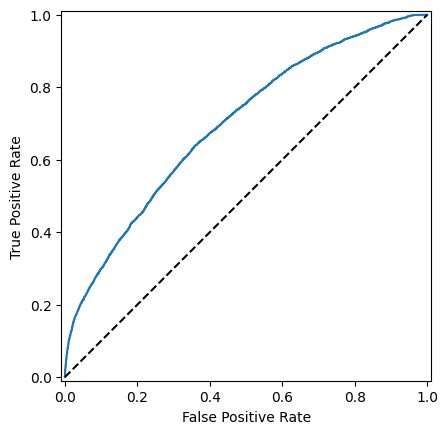

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_valid, y_pred_probs)

x = np.linspace(0, 1, 100)

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.plot(x, x, 'k--')
plt.savefig('./figs/roc_curve.png')

;
